***Laser Scan for Movies***

In [1]:
import sys
import pyvisa as visa # PyVisa info @ http://PyVisa.readthedocs.io/en/stable/
import datetime
import numpy as np
import matplotlib.pyplot as plt
import serial 
import time
print(serial.__file__)
ser = serial.Serial()

c:\Users\Jilli\anaconda3\Lib\site-packages\serial\__init__.py


Use this part for making movies with the data.

In [2]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
%matplotlib notebook
%matplotlib inline

In [3]:
import serial.tools.list_ports; 
print([comport.device for comport in serial.tools.list_ports.comports()])

['COM3']


In [ ]:
SCOPE_VISA_ADDRESS = "TCPIP0::134.153.36.224::hislip0::INSTR" # Get this from Keysight IO Libraries Connection Expert   
USER_REQUESTED_POINTS=50000
    ## Note: sockets are not supported in this revision of the script (though it is possible), and PyVisa 1.8 does not support HiSlip, nor do these scopes.
    ## Note: USB transfers are generally fastest.
    ## Video: Connecting to Instruments Over LAN, USB, and GPIB in Keysight Connection Expert: https://youtu.be/sZz8bNHX5u4

GLOBAL_TOUT =  10000 # IO time out in milliseconds

## Save Locations
BASE_FILE_NAME = "my_data"
BASE_DIRECTORY = "/Users/Directory/Your/Path/"

In [5]:
rm = visa.ResourceManager() # this uses PyVisa
## This is more or less ok too: rm = visa.ResourceManager('C:\\Program Files (x86)\\IVI Foundation\\VISA\\WinNT\\agvisa\\agbin\\visa32.dll')
## In fact, it is generally not needed to call it explicitly: rm = visa.ResourceManager()

## Open Connection
## Define & open the scope by the VISA address ; # This uses PyVisa
try:
    KsInfiniiVisionX = rm.open_resource(SCOPE_VISA_ADDRESS)
except Exception:
    print("Unable to connect to oscilloscope at " + str(SCOPE_VISA_ADDRESS) + ". Aborting script.\n")
    sys.exit()

## Set Global Timeout
## This can be used wherever, but local timeouts are used for Arming, Triggering, and Finishing the acquisition... Thus it mostly handles IO timeouts
KsInfiniiVisionX.timeout = GLOBAL_TOUT

## Clear the instrument bus
KsInfiniiVisionX.clear()

In [6]:
KsInfiniiVisionX.write(":WAVeform:POINts:MODE MAX") # MAX mode works for all acquisition types, so this is done here to avoid Acq. Type vs points mode problems. Adjusted later for specific acquisition types.
KsInfiniiVisionX.write(":WAVeform:FORMat WORD") # 16 bit word format... or BYTE for 8 bit format - WORD recommended, see more comments below when the data is actually retrieved
    ## WORD format especially  recommended  for Average and High Res. Acq. Types, which can produce more than 8 bits of resolution.
KsInfiniiVisionX.write(":WAVeform:BYTeorder LSBFirst") # Explicitly set this to avoid confusion - only applies to WORD FORMat
KsInfiniiVisionX.write(":WAVeform:UNSigned 0") # Explicitly set this to avoid confusion



22

In [10]:
#Turn on necessary channels
CH_TO_RECORD=[2]#[1,2]
CH_LIST=[1,2,3,4]

for ch in CH_LIST:
    if ch in CH_TO_RECORD:
        KsInfiniiVisionX.write(":CHANnel" + str(ch) + ":DISPlay ON") # Setting a channel to be a waveform source turns it on... so if here, turn it off.
    else:
        KsInfiniiVisionX.write(":CHANnel" + str(ch) + ":DISPlay OFF") # Setting a channel to be a waveform source turns it on... so if here, turn it off.

NUMBER_CHANNELS_ON=len(CH_TO_RECORD)



In [11]:
def Read_and_Write_Single_Channel_Data(scope,channel,fname,npoints=5000,n_aves=25):
 
    #Read data from the scope, using VISA and save it in numpy format
    #scope -- variable name for the scope
    #channel -- which channel to record
    #fname -- name of file to save data to (full path)
    #npoints -- 5000 number of points to save
    #n_aves -- number of waveforms to average
    scope.write(":STOP") 
    Channel_Acquired = int(scope.query(":WAVeform:SOURce CHANnel" + str(channel) + ";POINts?"))
    if Channel_Acquired == 0:
        print("error writing data file")
        return
    #Get preamble
    USER_REQUESTED_POINTS=npoints
    scope.write(":WAVeform:POINts " + str(USER_REQUESTED_POINTS))
    NUMBER_OF_POINTS_TO_ACTUALLY_RETRIEVE = int(scope.query(":WAVeform:POINts?"))


    Pre = scope.query(":WAVeform:PREamble?").split(',') 
    dat_scale  = float(Pre[7]) # Y INCrement, Voltage difference between data points; Could also be found with :WAVeform:YINCrement? after setting :WAVeform:SOURce
    dat_ref  = float(Pre[8]) # Y ORIGin, Voltage at center screen; Could also be found with :WAVeform:YORigin? after setting :WAVeform:SOURce
    dat_offset  = float(Pre[9]) # Y REFerence, Specifies the data point where y-origin occurs, always zero; Could also be found with :WAVeform:YREFerence? after setting :WAVeform:SOURce

    X_INCrement = float(Pre[4]) # Time difference between data points; Could also be found with :WAVeform:XINCrement? after setting :WAVeform:SOURce
    X_ORIGin    = float(Pre[5]) # Always the first data point in memory; Could also be found with :WAVeform:XORigin? after setting :WAVeform:SOURce
    X_REFerence = float(Pre[6]) # Specifies the data point associated with x-origin; The x-reference point is the first point displayed and XREFerence is always 0.; Could also be found with :WAVeform:XREFerence? after setting :WAVeform:SOURce
    DataTime = ((np.linspace(0,NUMBER_OF_POINTS_TO_ACTUALLY_RETRIEVE-1,NUMBER_OF_POINTS_TO_ACTUALLY_RETRIEVE)-X_REFerence)*X_INCrement)+X_ORIGin
    
    
    
    Wav_Data_ave = np.zeros([NUMBER_OF_POINTS_TO_ACTUALLY_RETRIEVE]) # ** divided this by 2 so Wav_Data_ave size doesnt cause error
    
    #if this throws an error, check the peak detect mode
    #Wav_Data_ave=np.zeros_like(Wav_Data)
    for ii in range(n_aves):
        Wav_Data_ave += np.array(scope.query_binary_values(':WAVeform:SOURce CHANnel' + str(channel) + ';DATA?', "h", False))/n_aves # See also: https://PyVisa.readthedocs.io/en/stable/rvalues.html#reading-binary-values

    Wav_Data_ave = (((Wav_Data_ave-dat_offset)*dat_scale)+dat_ref)

    NewData = (np.insert(Wav_Data_ave, 0, DataTime, axis = 0)).T

    filename = fname + ".npy"
    with open(filename, 'wb') as filehandle: # wb means open for writing in binary; can overwrite
        np.save(filehandle, NewData)
    scope.write(":RUN")    
    return DataTime,Wav_Data_ave

In [12]:
#KsInfiniiVisionX.write(":TIM:REF LEFT\n")  
#KsInfiniiVisionX.write(":TIM:SCAL 0.6us\n")    # adjust time scale on scope (ex. 500 ns/box = 0.5 us)
#KsInfiniiVisionX.write(":TIM:DEL 0.0us\n")    # set arrival time of probe
#KsInfiniiVisionX.write(":CHANnel3:SCALe 0.02\n") # V, vertical scale on scope (ex. 0.02 V = 20 mV/box in top left)
#fname_add="3A_SS_1FHMZ_A10-Ptransducer"
fname_add="Test"
DataTime,Wav_Data_ave=Read_and_Write_Single_Channel_Data(KsInfiniiVisionX,1,BASE_DIRECTORY+fname_add,n_aves=1)



In [13]:
ser.port="COM3"  #change this to the path to your serial port (or possibly just its name depending on your OS)

ser.baudrate = 9600
ser.bytesize = serial.EIGHTBITS		#number of bits per bytes
ser.parity = serial.PARITY_NONE		#set parity check: no parity
ser.stopbits = serial.STOPBITS_ONE	#number of stop bits

#ser.timeout = None		#block read
ser.timeout = 1			#non-block read
#ser.timeout = 2		        #timeout block read

ser.xonxoff = False		#disable software flow control
ser.rtscts = False		#disable hardware (RTS/CTS) flow control
ser.dsrdtr = False		#disable hardware (DSR/DTR) flow control
ser.writeTimeout = 2	        #timeout for write

ser.open() 

The motor will work and connected if it prints "J".

In [14]:
 #connect to the stage
ser.write("V".encode())  #check that you are connected, 
out=ser.readline()
print(out.decode())

J


This will make the motor move to (0,0).

In [15]:
ser.write("F,C,I1M-0,R".encode())  #move all the way to the left (-), change the number to choose a new position
time.sleep(30)
ser.write("N".encode())
time.sleep(.5)
ser.write("F,C,I2M0,R".encode())  #move all the way to the bottom (+)
time.sleep(30)  #wait 30 seconds, note if you don't wait long enough this will not work
ser.write("N".encode())  #reset the counter to zero here 



1

In [18]:
def GetLoc():
    ser.write("Y".encode())  #tell the stage you want to know about the y (vertical) axis
    pos=ser.readline()       #read the info from the scope
    pos1=pos.decode()        #change it from bytes to numbers

    #remove weird characters from the beginning
    ii=0
    while not(pos1[ii]=='+' or pos1[ii]=='-'):
        ii=ii+1
    # extract sign
    sign=1                   
    if pos1[ii]=='-':
        sign=-1
    #convert to integer
    pos1 = int(''.join([x for x in pos1[ii:] if x.isdigit()])) # parseint
    #incorporate the sign into the integer
    pos1=sign*pos1

    #Now repeat for the x-axis
    ser.write("X".encode())
    pos=ser.readline()
    pos2=pos.decode()
    ii=0
    while not(pos2[ii]=='+' or pos2[ii]=='-'):
        ii=ii+1
    sign=1
    if pos2[ii]=='-':
        sign=-1
    pos2 = int(''.join([x for x in pos2[ii:] if x.isdigit()])) # parseint
    pos2=sign*pos2
            #Y, X
    return pos1,pos2



In [19]:
posy,posx=GetLoc()
print(posx,posy)

0 0


In [20]:
def Move(Xmm,Ymm,waittime=10,Xmax=43000,Ymin=-48000):
    #Move Xmm in the x-direction (- numbers goes to left, + numbers goes to right)
    #Move Ymm in the y-direction (- numbers goes up, + numbers goes to down)
    #waittime=10 time to wait between motions for the stage to finish moving
    #Xmax=43000 maximum distance stage can move in X (in revolutions)
    #Ymax=-48000 maximum distance stage can move in Y (in revolutions)
    #With failsafe to ensure that it doesn't go too far on any axis.
    #But that failsafe is not perfect, you should reset the origin before using this code for large motions
   
    #First convert the distances to revolutions:
    StepsPermm = 400 / (2.54)   #stage motion is 400 revolutions per 0.1 inch, convert to mm
    
    Distx_rev=Xmm*StepsPermm
    Disty_rev=Ymm*StepsPermm
   
    #Find current position (for error trapping)
    posy,posx=GetLoc()
#    print(posx,posy)
    #wait for it to finish
    time.sleep(waittime)
    #Move the stage in x if distance is OK
    if np.abs(Xmm)>0:
        if ((posx+Distx_rev)<Xmax and (posx+Distx_rev)>0):
            ser.write(("F,C,I1M"+str(round(Distx_rev,0))+",R").encode()) 
        else: 
            print("Asked to move too far in X, moving to max allowed")
            if (posx+Distx_rev)>=Xmax:
                ser.write(("F,C,IA1M"+str(round(Xmax,0))+",R").encode())
            else:
                ser.write(("F,C,IA1M"+str(0)+",R").encode())
     
    #Wait for it to finish moving
        time.sleep(waittime)
    
    #repeat in Y
    if np.abs(Ymm)>0:
        if ((posy+Disty_rev)>Ymin and (posy+Disty_rev)<0):
            ser.write(("F,C,I2M"+str(round(Disty_rev,0))+",R").encode())  
        else: 
            print("Asked to move too far in Y, moving to max allowed")
            if (posy+Disty_rev)<Ymin:
                ser.write(("F,C,IA2M"+str(Ymin)+",R").encode())
            else:
                ser.write(("F,C,IA2M"+str(0)+",R").encode())




In [21]:
def CoordMove(Xmm,Ymm,waittime=10,Xmax=43000,Ymin=-48000):
    #Move Xmm in the x-direction (- numbers goes to left, + numbers goes to right)
    #Move Ymm in the y-direction (- numbers goes up, + numbers goes to down)
    #waittime=10 time to wait between motions for the stage to finish moving
    #Xmax=43000 maximum distance stage can move in X (in revolutions)
    #Ymax=-48000 maximum distance stage can move in Y (in revolutions)

#With failsafe to ensure that it doesn't go too far on any axis.
    
    #First convert the distances to revolutions:
    StepsPermm = 400 / (2.54)   #stage motion is 400 revolutions per 0.1 inch, convert to mm
    
    Distx_rev=Xmm*StepsPermm
    Disty_rev=Ymm*StepsPermm
   
    #Find current position (for error trapping)
    posy,posx=GetLoc()
    
    
    #wait for it to finish
    time.sleep(waittime)
    #Move the stage in x if distance is OK
    if ((Distx_rev)<Xmax and Distx_rev>0):
        ser.write(("F,C,IA1M"+str(round(Distx_rev,0))+",R").encode()) 
    else: 
        print("Asked to move too far in X, moving to max location")
        if Distx_rev>Xmax:
            ser.write(("F,C,IA1M"+str(round(Xmax,0))+",R").encode())
        else: 
            ser.write(("F,C,IA1M"+str(0)+",R").encode())
     
    #Wait for it to finish moving
    time.sleep(waittime)
    
    #repeat in Y
    if ((Disty_rev)>Ymin and Disty_rev<0):
        print('moving')
        print(Disty_rev)
        ser.write(("F,C,IA2M"+str(round(Disty_rev,0))+",R").encode())  
    else: 
        print("Asked to move too far in Y, moving to max allowed")
        if Disty_rev<0:
            ser.write(("F,C,IA2M"+str(Ymin)+",R").encode())
        else:
            ser.write(("F,C,IA2M"+str(0)+",R").encode())

                      



In [23]:
#posy,posx=GetLoc()
#print(posx/400*2.54,posy/400*2.54)
#ser.write(("F,C,IA2M"+str(round(0*400/2.54,0))+",R").encode()) 
#CoordMove(145,-100)
Move(0,-188)#145,-100


In [24]:
posy,posx=GetLoc()
print(posx/400*2.54,posy/400*2.54)


174.99964999999997 -187.9981


Use the above setup to get the laser to the starting point of your scan.  

In [26]:
Xmax=44
Ymax=44
dx=4
dy=4
Xvector=np.arange(0,Xmax,dx)
Yvector=np.arange(0,Ymax,dy)
nx=np.size(Xvector)
ny=np.size(Yvector)

In [ ]:
waittime = 1.0

for x in Xvector:
    for y in Yvector:
        fname_add = f"Test_x{x}_y{y}"
        DataTime, Wav_Data_ave = Read_and_Write_Single_Channel_Data(
             KsInfiniiVisionX, 1, BASE_DIRECTORY + fname_add, n_aves=1
         )

        time.sleep(waittime)  
        posy, posx = GetLoc()
        print(f"Moving to x={x}, y={y} -> Actual position: x={posx/400*2.54:.2f} mm, y={posy/400*2.54:.2f} mm")

        if y < Yvector[-1]:
            step = -dy if abs(y - Yvector[-1]) >= dy else -(Yvector[-1] - y)
            Move(0, step, waittime=waittime)
            time.sleep(waittime)

    if x < Xvector[-1]:
        Move(dx, 0, waittime=3*waittime)  
        time.sleep(3*waittime)

        Move(0, Yvector[-1], waittime=3*waittime)  
        time.sleep(3*waittime)

Moving to x=0, y=0 -> Actual position: x=175.00 mm, y=-188.00 mm
Moving to x=0, y=4 -> Actual position: x=175.00 mm, y=-192.00 mm
Moving to x=0, y=8 -> Actual position: x=175.00 mm, y=-196.00 mm
Moving to x=0, y=12 -> Actual position: x=175.00 mm, y=-200.00 mm
Moving to x=0, y=16 -> Actual position: x=175.00 mm, y=-204.00 mm
Moving to x=0, y=20 -> Actual position: x=175.00 mm, y=-208.00 mm
Moving to x=0, y=24 -> Actual position: x=175.00 mm, y=-212.00 mm
Moving to x=0, y=28 -> Actual position: x=175.00 mm, y=-216.00 mm
Moving to x=0, y=32 -> Actual position: x=175.00 mm, y=-220.00 mm
Moving to x=0, y=36 -> Actual position: x=175.00 mm, y=-224.00 mm
Moving to x=0, y=40 -> Actual position: x=175.00 mm, y=-228.00 mm
Moving to x=4, y=0 -> Actual position: x=179.00 mm, y=-188.00 mm
Moving to x=4, y=4 -> Actual position: x=179.00 mm, y=-192.00 mm
Moving to x=4, y=8 -> Actual position: x=179.00 mm, y=-196.01 mm
Moving to x=4, y=12 -> Actual position: x=179.00 mm, y=-200.01 mm
Moving to x=4, y

## Actually make the movie

In [5]:
nt = 3839
nx = 10
ny = 10
Xvector = Yvector = np.arange(0, 40, 4)
DatMat = np.zeros([nx, ny, nt])

for ix in range(nx):
    for iy in range(ny):
        fname_add = f"Test_x{Xvector[ix]}_y{Yvector[iy]}"
        fname = BASE_DIRECTORY + fname_add + ".npy"
        data = np.load(fname)

        curdat = np.reshape(data[:2 * nt], [2, nt])  
        if ix == 0:
            if iy == 0:
                print(curdat)       
        DatMat[ix, iy, :] = curdat[1, :]

[[-1.00000000e-05 -9.97395875e-06 -9.94791750e-06 ...  8.98942350e-05
   8.99202763e-05  8.99463175e-05]
 [-3.66080366e-02 -3.66080366e-02 -3.66080366e-02 ...  1.31406989e-02
   1.26381864e-02  1.16331614e-02]]


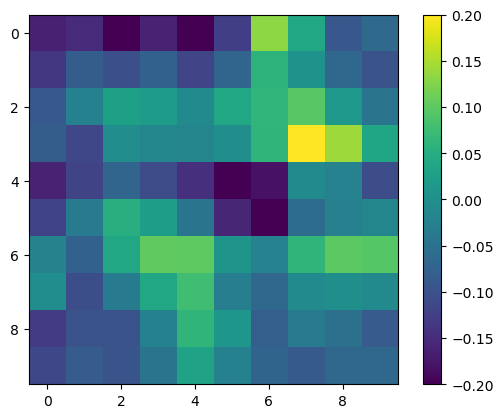

In [8]:
plt.imshow(DatMat[:,:,2200],clim=[-.2,.2])  
plt.colorbar()

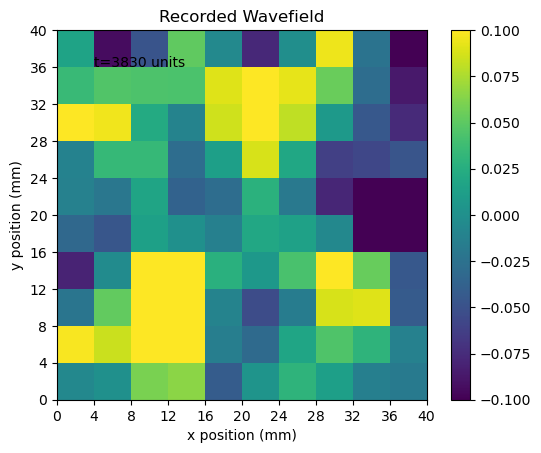

In [9]:
fig, ax = plt.subplots()
plt.xlabel('x position (mm)')
plt.ylabel('y position (mm)')
plt.title('Recorded Wavefield')

anivec=np.arange(3840,7680,10)
anivec=np.subtract(anivec,3840)

im = ax.imshow(DatMat[:, :, anivec[0]].reshape([nx, ny]).T,
               extent=[0, 40, 0, 40],
               clim=[-.1, .1], animated=True)

# colorbar
cbar = fig.colorbar(im, ax=ax)

ticks = np.arange(0, 44, 4) 
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ims = []
for ii in anivec:
    im = ax.imshow(DatMat[:, :, ii].reshape([nx, ny]).T,
                   extent=[0, 40, 0, 40], 
                   clim=[-0.1, 0.1], animated=True)
    im2 = ax.text(4, 36, f"t={ii} units") 
    ims.append([im, im2])

ani = animation.ArtistAnimation(fig, ims)

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('FWD2.gif', writer=writer)

plt.show()

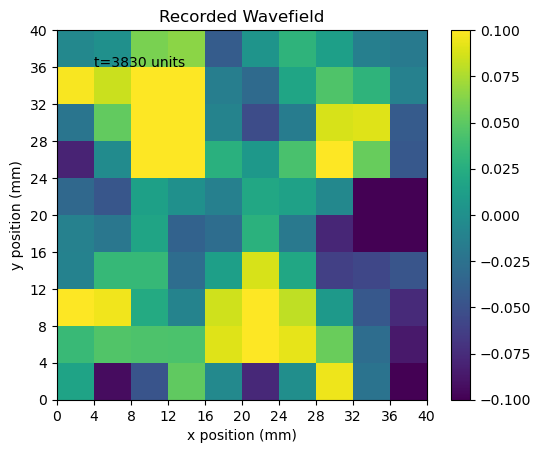

In [6]:
fig, ax = plt.subplots()
plt.xlabel('x position (mm)')
plt.ylabel('y position (mm)')
plt.title('Recorded Wavefield')

anivec = np.arange(3840, 7680, 10)
anivec = np.subtract(anivec, 3840)

# Flip the initial frame vertically
im = ax.imshow(np.flipud(DatMat[:, :, anivec[0]].reshape([nx, ny]).T),
               extent=[0, 40, 0, 40],
               clim=[-0.1, 0.1], animated=True)

# Colorbar
cbar = fig.colorbar(im, ax=ax)

ticks = np.arange(0, 44, 4)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ims = []
for ii in anivec:
    im = ax.imshow(np.flipud(DatMat[:, :, ii].reshape([nx, ny]).T),
                   extent=[0, 40, 0, 40], 
                   clim=[-0.1, 0.1], animated=True)
    im2 = ax.text(4, 36, f"t={ii} units") 
    ims.append([im, im2])

ani = animation.ArtistAnimation(fig, ims)

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('FWD3.gif', writer=writer)

plt.show()


(1000.0, 3000.0)

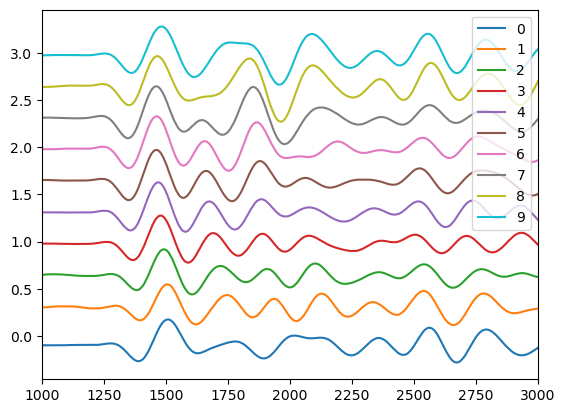

In [35]:
plt.figure()
for ii in range(ny):
    plt.plot(DatMat[1,ii,:]+ii/3,label=str(ii))
plt.legend()
plt.xlim([1000,3000])

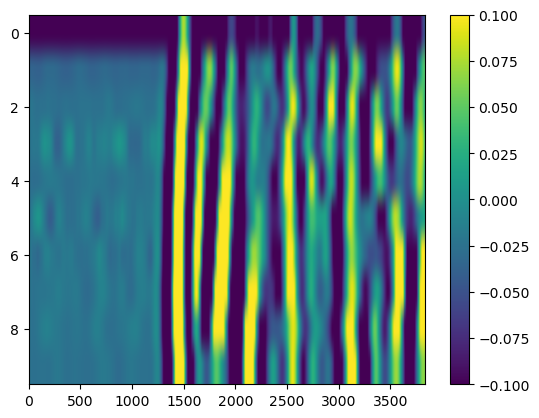

In [32]:
plt.figure()
plt.imshow(DatMat[2,:,:],aspect='auto', clim=([-0.1, 0.1]))
plt.colorbar()

In [26]:
np.shape(DatMat)

(10, 10, 3839)

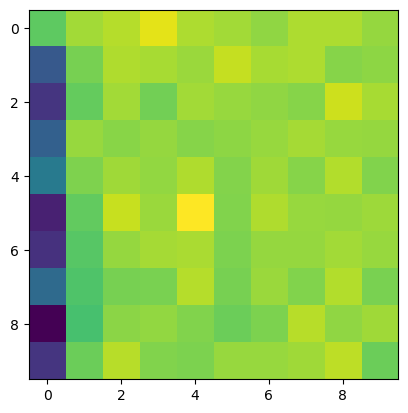

In [29]:
plt.figure()
plt.imshow(DatMat[:,:,1000])